In [1]:
%matplotlib inline
import pyfolio as pf

In [2]:
import zipline
from zipline.api import *
from zipline.utils.events import BeforeClose
from zipline.utils.run_algo import run_algorithm
from datetime import datetime, timedelta
import pytz
import pandas as pd
import pandas_datareader.data as web

In [3]:
!zipline bundles

quandl <no ingestions>
quantopian-quandl 2017-09-27 10:45:08.190035


In [4]:
candles = 3
ticker = 'SPY'
from_date = datetime(2000,1,1, tzinfo=pytz.utc)
to_date = datetime(2014,1,1, tzinfo=pytz.utc)
capital_base = 10000

In [5]:
def initialize(context):
    context.i = 0
    context.asset = symbol(ticker)

def handle_data(context, data):
    context.i += 1
    if context.i < candles:
        return

    #always close previous day
    order_percent(context.asset, 0)

    hist = data.history(context.asset, 
                           ('open', 'high', 'low', 'close'), 
                           bar_count=candles, 
                           frequency="1d")
    current_candle = hist.iloc[-1]
    
    all_negative = ((hist['close'] - hist['open']) < 0).all()
    if all_negative:
        #current_candle = hist.iloc[-1]
        lower_bound = current_candle['low'] + (current_candle['high']-current_candle['low'])*0.75
        if current_candle['close'] > lower_bound:
            act_price = data.current(context.asset, 'price')
            print('==========\n{}\n'.format(context.datetime))
            print(hist)
            print('\ncurrent:')
            print(data.current(context.asset, ('open', 'high', 'low', 'close')))
            order_percent(context.asset, 5)
            record(history=hist)

# Data loading

### Simulate minute data

In [6]:
start = pd.Timedelta(hours=14, minutes=30)
stop = pd.Timedelta(hours=21, minutes=0)
open_minutes = 6*60+30 # 14:30 - 21:00
def new_minute_line(data, idx:int, step_size:int): # time_shift in minutes
    time_shift = idx*step_size
    indexes = data.index + pd.Timedelta(minutes=time_shift) + start
    diff = data['Close'] - data['Open']
    step = diff/open_minutes
    opens = data['Open'] + step*time_shift
    closes = opens + step*step_size
    ret = pd.DataFrame(index=indexes, data={'Open':opens.values, 'Close': closes.values})
    ret['High'] = ret[['Open','Close']].max(axis=1)*1.001
    ret['Low'] = ret[['Open','Close']].min(axis=1)*0.999
    ret['Volume'] = 0
    ret = ret[['Open', 'High', 'Low', 'Close', 'Volume']]
    return ret

### Load data from Yahoo, and fill minute data based on estimations

In [7]:
def load_data(ticker, from_date, to_date):
    from collections import OrderedDict
    data = OrderedDict()
    
    df = web.DataReader(ticker, 'yahoo', from_date, to_date)
    df.dropna(inplace=True)
    df.drop(['Adj Close'], axis=1, inplace=True)
    
    new_df = pd.DataFrame()
    step_size = 5
    for idx in range(0, open_minutes//step_size):
        new_line = new_minute_line(df, idx, step_size)
        new_df = new_df.append(new_line)
    new_df = new_df.append(df)
    new_df.sort_index(inplace=True)
    
    data[ticker] = new_df
    panel = pd.Panel(data)
    panel.minor_axis = ['open', 'high', 'low', 'close', 'volume']
    panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

    return panel

In [8]:
data_path = './SPY.pkl'
#spy_df = load_data('SPY', from_date, to_date)
#spy_df.to_pickle(data_path)
spy_df = pd.read_pickle(data_path)

In [9]:
spy_df['SPY']['2010-01-04'].head(2)

,open,high,low,close,volume
Date,,,,,
2010-01-04 00:00:00+00:00,112.370003,113.389999,111.510002,113.330002,118944600.0
2010-01-04 14:30:00+00:00,112.370003,112.494693,112.257633,112.382311,0.0


In [10]:
spy_df['SPY']['2010-01-04'].tail(1)

,open,high,low,close,volume
Date,,,,,
2010-01-04 20:55:00+00:00,113.317694,113.443332,113.204377,113.330002,0.0


In [11]:
results = run_algorithm(from_date, 
                        to_date,
                        initialize,
                        capital_base,
                        handle_data=handle_data,
                        data=spy_df)

##############
2000-01-03 21:00:00+00:00


##############
2000-01-04 21:00:00+00:00


##############
2000-01-05 21:00:00+00:00


##############
2000-01-06 21:00:00+00:00


##############
2000-01-07 21:00:00+00:00


##############
2000-01-10 21:00:00+00:00


##############
2000-01-11 21:00:00+00:00


##############
2000-01-12 21:00:00+00:00


##############
2000-01-13 21:00:00+00:00


##############
2000-01-14 21:00:00+00:00


##############
2000-01-18 21:00:00+00:00


##############
2000-01-19 21:00:00+00:00


##############
2000-01-20 21:00:00+00:00


##############
2000-01-21 21:00:00+00:00


##############
2000-01-24 21:00:00+00:00




/usr/local/lib/python3.4/site-packages/empyrical/stats.py:522: RuntimeWarning: invalid value encountered in double_scalars
  sortino = mu / dsr


##############
2000-01-25 21:00:00+00:00


##############
2000-01-26 21:00:00+00:00


##############
2000-01-27 21:00:00+00:00


##############
2000-01-28 21:00:00+00:00


##############
2000-01-31 21:00:00+00:00


##############
2000-02-01 21:00:00+00:00


##############
2000-02-02 21:00:00+00:00


##############
2000-02-03 21:00:00+00:00


##############
2000-02-04 21:00:00+00:00


##############
2000-02-07 21:00:00+00:00


##############
2000-02-08 21:00:00+00:00


##############
2000-02-09 21:00:00+00:00


##############
2000-02-10 21:00:00+00:00


##############
2000-02-11 21:00:00+00:00


##############
2000-02-14 21:00:00+00:00


                             close     high      low     open
2000-02-10 00:00:00+00:00  141.562  142.562  140.875  141.625
2000-02-11 00:00:00+00:00  138.688  141.938  138.031  141.844
2000-02-14 00:00:00+00:00  139.500  139.781  138.312  139.781
##############
2000-02-15 21:00:00+00:00


##############
2000-02-16 21:00:00+00:00


##############
2000-0

##############
2000-10-20 20:00:00+00:00


##############
2000-10-23 20:00:00+00:00


##############
2000-10-24 20:00:00+00:00


##############
2000-10-25 20:00:00+00:00


##############
2000-10-26 20:00:00+00:00


##############
2000-10-27 20:00:00+00:00


##############
2000-10-30 21:00:00+00:00


##############
2000-10-31 21:00:00+00:00


##############
2000-11-01 21:00:00+00:00


##############
2000-11-02 21:00:00+00:00


##############
2000-11-03 21:00:00+00:00


##############
2000-11-06 21:00:00+00:00


##############
2000-11-07 21:00:00+00:00


##############
2000-11-08 21:00:00+00:00


##############
2000-11-09 21:00:00+00:00


##############
2000-11-10 21:00:00+00:00


##############
2000-11-13 21:00:00+00:00


##############
2000-11-14 21:00:00+00:00


##############
2000-11-15 21:00:00+00:00


##############
2000-11-16 21:00:00+00:00


##############
2000-11-17 21:00:00+00:00


##############
2000-11-20 21:00:00+00:00


##############
2000-11-21 21:00:00+00:00


###########

##############
2001-07-16 20:00:00+00:00


##############
2001-07-17 20:00:00+00:00


##############
2001-07-18 20:00:00+00:00


##############
2001-07-19 20:00:00+00:00


##############
2001-07-20 20:00:00+00:00


##############
2001-07-23 20:00:00+00:00


##############
2001-07-24 20:00:00+00:00


##############
2001-07-25 20:00:00+00:00


##############
2001-07-26 20:00:00+00:00


##############
2001-07-27 20:00:00+00:00


##############
2001-07-30 20:00:00+00:00


##############
2001-07-31 20:00:00+00:00


##############
2001-08-01 20:00:00+00:00


##############
2001-08-02 20:00:00+00:00


##############
2001-08-03 20:00:00+00:00


##############
2001-08-06 20:00:00+00:00


##############
2001-08-07 20:00:00+00:00


##############
2001-08-08 20:00:00+00:00


##############
2001-08-09 20:00:00+00:00


##############
2001-08-10 20:00:00+00:00


##############
2001-08-13 20:00:00+00:00


##############
2001-08-14 20:00:00+00:00


##############
2001-08-15 20:00:00+00:00


###########

##############
2002-04-25 20:00:00+00:00


##############
2002-04-26 20:00:00+00:00


##############
2002-04-29 20:00:00+00:00


##############
2002-04-30 20:00:00+00:00


##############
2002-05-01 20:00:00+00:00


##############
2002-05-02 20:00:00+00:00


##############
2002-05-03 20:00:00+00:00


##############
2002-05-06 20:00:00+00:00


##############
2002-05-07 20:00:00+00:00


##############
2002-05-08 20:00:00+00:00


##############
2002-05-09 20:00:00+00:00


##############
2002-05-10 20:00:00+00:00


##############
2002-05-13 20:00:00+00:00


##############
2002-05-14 20:00:00+00:00


##############
2002-05-15 20:00:00+00:00


##############
2002-05-16 20:00:00+00:00


##############
2002-05-17 20:00:00+00:00


##############
2002-05-20 20:00:00+00:00


##############
2002-05-21 20:00:00+00:00


##############
2002-05-22 20:00:00+00:00


##############
2002-05-23 20:00:00+00:00


##############
2002-05-24 20:00:00+00:00


##############
2002-05-28 20:00:00+00:00


###########

##############
2003-02-14 21:00:00+00:00


##############
2003-02-18 21:00:00+00:00


##############
2003-02-19 21:00:00+00:00


##############
2003-02-20 21:00:00+00:00


##############
2003-02-21 21:00:00+00:00


##############
2003-02-24 21:00:00+00:00


##############
2003-02-25 21:00:00+00:00


##############
2003-02-26 21:00:00+00:00


##############
2003-02-27 21:00:00+00:00


##############
2003-02-28 21:00:00+00:00


##############
2003-03-03 21:00:00+00:00


##############
2003-03-04 21:00:00+00:00


##############
2003-03-05 21:00:00+00:00


##############
2003-03-06 21:00:00+00:00


##############
2003-03-07 21:00:00+00:00


##############
2003-03-10 21:00:00+00:00


##############
2003-03-11 21:00:00+00:00


##############
2003-03-12 21:00:00+00:00


##############
2003-03-13 21:00:00+00:00


##############
2003-03-14 21:00:00+00:00


##############
2003-03-17 21:00:00+00:00


##############
2003-03-18 21:00:00+00:00


##############
2003-03-19 21:00:00+00:00


###########

##############
2003-11-19 21:00:00+00:00


##############
2003-11-20 21:00:00+00:00


##############
2003-11-21 21:00:00+00:00


##############
2003-11-24 21:00:00+00:00


##############
2003-11-25 21:00:00+00:00


##############
2003-11-26 21:00:00+00:00


##############
2003-11-28 18:00:00+00:00


##############
2003-12-01 21:00:00+00:00


##############
2003-12-02 21:00:00+00:00


##############
2003-12-03 21:00:00+00:00


##############
2003-12-04 21:00:00+00:00


##############
2003-12-05 21:00:00+00:00


##############
2003-12-08 21:00:00+00:00


##############
2003-12-09 21:00:00+00:00


##############
2003-12-10 21:00:00+00:00


##############
2003-12-11 21:00:00+00:00


##############
2003-12-12 21:00:00+00:00


##############
2003-12-15 21:00:00+00:00


##############
2003-12-16 21:00:00+00:00


##############
2003-12-17 21:00:00+00:00


##############
2003-12-18 21:00:00+00:00


##############
2003-12-19 21:00:00+00:00


##############
2003-12-22 21:00:00+00:00


###########

##############
2004-09-15 20:00:00+00:00


##############
2004-09-16 20:00:00+00:00


##############
2004-09-17 20:00:00+00:00


##############
2004-09-20 20:00:00+00:00


##############
2004-09-21 20:00:00+00:00


##############
2004-09-22 20:00:00+00:00


##############
2004-09-23 20:00:00+00:00


##############
2004-09-24 20:00:00+00:00


##############
2004-09-27 20:00:00+00:00


##############
2004-09-28 20:00:00+00:00


##############
2004-09-29 20:00:00+00:00


##############
2004-09-30 20:00:00+00:00


##############
2004-10-01 20:00:00+00:00


##############
2004-10-04 20:00:00+00:00


##############
2004-10-05 20:00:00+00:00


##############
2004-10-06 20:00:00+00:00


##############
2004-10-07 20:00:00+00:00


##############
2004-10-08 20:00:00+00:00


##############
2004-10-11 20:00:00+00:00


##############
2004-10-12 20:00:00+00:00


##############
2004-10-13 20:00:00+00:00


##############
2004-10-14 20:00:00+00:00


##############
2004-10-15 20:00:00+00:00


###########

##############
2005-07-05 20:00:00+00:00


##############
2005-07-06 20:00:00+00:00


##############
2005-07-07 20:00:00+00:00


##############
2005-07-08 20:00:00+00:00


##############
2005-07-11 20:00:00+00:00


##############
2005-07-12 20:00:00+00:00


##############
2005-07-13 20:00:00+00:00


##############
2005-07-14 20:00:00+00:00


##############
2005-07-15 20:00:00+00:00


##############
2005-07-18 20:00:00+00:00


##############
2005-07-19 20:00:00+00:00


##############
2005-07-20 20:00:00+00:00


##############
2005-07-21 20:00:00+00:00


##############
2005-07-22 20:00:00+00:00


##############
2005-07-25 20:00:00+00:00


##############
2005-07-26 20:00:00+00:00


##############
2005-07-27 20:00:00+00:00


##############
2005-07-28 20:00:00+00:00


##############
2005-07-29 20:00:00+00:00


##############
2005-08-01 20:00:00+00:00


##############
2005-08-02 20:00:00+00:00


##############
2005-08-03 20:00:00+00:00


##############
2005-08-04 20:00:00+00:00


###########


##############
2006-05-02 20:00:00+00:00


##############
2006-05-03 20:00:00+00:00


##############
2006-05-04 20:00:00+00:00


##############
2006-05-05 20:00:00+00:00


##############
2006-05-08 20:00:00+00:00


##############
2006-05-09 20:00:00+00:00


##############
2006-05-10 20:00:00+00:00


##############
2006-05-11 20:00:00+00:00


##############
2006-05-12 20:00:00+00:00


##############
2006-05-15 20:00:00+00:00


##############
2006-05-16 20:00:00+00:00


##############
2006-05-17 20:00:00+00:00


##############
2006-05-18 20:00:00+00:00


##############
2006-05-19 20:00:00+00:00


##############
2006-05-22 20:00:00+00:00


##############
2006-05-23 20:00:00+00:00


##############
2006-05-24 20:00:00+00:00


##############
2006-05-25 20:00:00+00:00


##############
2006-05-26 20:00:00+00:00


##############
2006-05-30 20:00:00+00:00


##############
2006-05-31 20:00:00+00:00


##############
2006-06-01 20:00:00+00:00


##############
2006-06-02 20:00:00+00:00


##########

##############
2007-02-16 21:00:00+00:00


##############
2007-02-20 21:00:00+00:00


##############
2007-02-21 21:00:00+00:00


##############
2007-02-22 21:00:00+00:00


##############
2007-02-23 21:00:00+00:00


##############
2007-02-26 21:00:00+00:00


##############
2007-02-27 21:00:00+00:00


##############
2007-02-28 21:00:00+00:00


##############
2007-03-01 21:00:00+00:00


##############
2007-03-02 21:00:00+00:00


##############
2007-03-05 21:00:00+00:00


##############
2007-03-06 21:00:00+00:00


##############
2007-03-07 21:00:00+00:00


##############
2007-03-08 21:00:00+00:00


##############
2007-03-09 21:00:00+00:00


##############
2007-03-12 20:00:00+00:00


##############
2007-03-13 20:00:00+00:00


##############
2007-03-14 20:00:00+00:00


##############
2007-03-15 20:00:00+00:00


##############
2007-03-16 20:00:00+00:00


##############
2007-03-19 20:00:00+00:00


##############
2007-03-20 20:00:00+00:00


##############
2007-03-21 20:00:00+00:00


###########

##############
2007-11-23 18:00:00+00:00


##############
2007-11-26 21:00:00+00:00


##############
2007-11-27 21:00:00+00:00


##############
2007-11-28 21:00:00+00:00


##############
2007-11-29 21:00:00+00:00


##############
2007-11-30 21:00:00+00:00


##############
2007-12-03 21:00:00+00:00


##############
2007-12-04 21:00:00+00:00


##############
2007-12-05 21:00:00+00:00


##############
2007-12-06 21:00:00+00:00


##############
2007-12-07 21:00:00+00:00


##############
2007-12-10 21:00:00+00:00


##############
2007-12-11 21:00:00+00:00


##############
2007-12-12 21:00:00+00:00


##############
2007-12-13 21:00:00+00:00


##############
2007-12-14 21:00:00+00:00


##############
2007-12-17 21:00:00+00:00


##############
2007-12-18 21:00:00+00:00


                            close    high     low    open
2007-12-14 00:00:00+00:00  147.17  149.10  147.10  147.93
2007-12-17 00:00:00+00:00  145.07  146.87  144.86  146.61
2007-12-18 00:00:00+00:00  145.88  146.48  143.96  1

##############
2008-08-21 20:00:00+00:00


##############
2008-08-22 20:00:00+00:00


##############
2008-08-25 20:00:00+00:00


##############
2008-08-26 20:00:00+00:00


##############
2008-08-27 20:00:00+00:00


##############
2008-08-28 20:00:00+00:00


##############
2008-08-29 20:00:00+00:00


##############
2008-09-02 20:00:00+00:00


##############
2008-09-03 20:00:00+00:00


##############
2008-09-04 20:00:00+00:00


##############
2008-09-05 20:00:00+00:00


##############
2008-09-08 20:00:00+00:00


##############
2008-09-09 20:00:00+00:00


##############
2008-09-10 20:00:00+00:00


##############
2008-09-11 20:00:00+00:00


##############
2008-09-12 20:00:00+00:00


##############
2008-09-15 20:00:00+00:00


##############
2008-09-16 20:00:00+00:00


##############
2008-09-17 20:00:00+00:00


##############
2008-09-18 20:00:00+00:00


##############
2008-09-19 20:00:00+00:00


##############
2008-09-22 20:00:00+00:00


##############
2008-09-23 20:00:00+00:00


###########

##############
2009-06-16 20:00:00+00:00


##############
2009-06-17 20:00:00+00:00


##############
2009-06-18 20:00:00+00:00


##############
2009-06-19 20:00:00+00:00


##############
2009-06-22 20:00:00+00:00


##############
2009-06-23 20:00:00+00:00


##############
2009-06-24 20:00:00+00:00


##############
2009-06-25 20:00:00+00:00


##############
2009-06-26 20:00:00+00:00


##############
2009-06-29 20:00:00+00:00


##############
2009-06-30 20:00:00+00:00


##############
2009-07-01 20:00:00+00:00


##############
2009-07-02 20:00:00+00:00


##############
2009-07-06 20:00:00+00:00


##############
2009-07-07 20:00:00+00:00


##############
2009-07-08 20:00:00+00:00


##############
2009-07-09 20:00:00+00:00


##############
2009-07-10 20:00:00+00:00


##############
2009-07-13 20:00:00+00:00


##############
2009-07-14 20:00:00+00:00


##############
2009-07-15 20:00:00+00:00


##############
2009-07-16 20:00:00+00:00


##############
2009-07-17 20:00:00+00:00


###########

##############
2010-03-31 20:00:00+00:00


##############
2010-04-01 20:00:00+00:00


##############
2010-04-05 20:00:00+00:00


##############
2010-04-06 20:00:00+00:00


##############
2010-04-07 20:00:00+00:00


##############
2010-04-08 20:00:00+00:00


##############
2010-04-09 20:00:00+00:00


##############
2010-04-12 20:00:00+00:00


##############
2010-04-13 20:00:00+00:00


##############
2010-04-14 20:00:00+00:00


##############
2010-04-15 20:00:00+00:00


##############
2010-04-16 20:00:00+00:00


##############
2010-04-19 20:00:00+00:00


##############
2010-04-20 20:00:00+00:00


##############
2010-04-21 20:00:00+00:00


##############
2010-04-22 20:00:00+00:00


##############
2010-04-23 20:00:00+00:00


##############
2010-04-26 20:00:00+00:00


##############
2010-04-27 20:00:00+00:00


##############
2010-04-28 20:00:00+00:00


##############
2010-04-29 20:00:00+00:00


##############
2010-04-30 20:00:00+00:00


##############
2010-05-03 20:00:00+00:00


###########

##############
2011-01-03 21:00:00+00:00


##############
2011-01-04 21:00:00+00:00


##############
2011-01-05 21:00:00+00:00


##############
2011-01-06 21:00:00+00:00


##############
2011-01-07 21:00:00+00:00


##############
2011-01-10 21:00:00+00:00


##############
2011-01-11 21:00:00+00:00


##############
2011-01-12 21:00:00+00:00


##############
2011-01-13 21:00:00+00:00


##############
2011-01-14 21:00:00+00:00


##############
2011-01-18 21:00:00+00:00


##############
2011-01-19 21:00:00+00:00


##############
2011-01-20 21:00:00+00:00


##############
2011-01-21 21:00:00+00:00


##############
2011-01-24 21:00:00+00:00


##############
2011-01-25 21:00:00+00:00


##############
2011-01-26 21:00:00+00:00


##############
2011-01-27 21:00:00+00:00


##############
2011-01-28 21:00:00+00:00


##############
2011-01-31 21:00:00+00:00


##############
2011-02-01 21:00:00+00:00


##############
2011-02-02 21:00:00+00:00


##############
2011-02-03 21:00:00+00:00


###########

##############
2011-10-14 20:00:00+00:00


##############
2011-10-17 20:00:00+00:00


##############
2011-10-18 20:00:00+00:00


##############
2011-10-19 20:00:00+00:00


##############
2011-10-20 20:00:00+00:00


##############
2011-10-21 20:00:00+00:00


##############
2011-10-24 20:00:00+00:00


##############
2011-10-25 20:00:00+00:00


##############
2011-10-26 20:00:00+00:00


##############
2011-10-27 20:00:00+00:00


##############
2011-10-28 20:00:00+00:00


##############
2011-10-31 20:00:00+00:00


##############
2011-11-01 20:00:00+00:00


##############
2011-11-02 20:00:00+00:00


##############
2011-11-03 20:00:00+00:00


##############
2011-11-04 20:00:00+00:00


##############
2011-11-07 21:00:00+00:00


##############
2011-11-08 21:00:00+00:00


##############
2011-11-09 21:00:00+00:00


##############
2011-11-10 21:00:00+00:00


##############
2011-11-11 21:00:00+00:00


##############
2011-11-14 21:00:00+00:00


##############
2011-11-15 21:00:00+00:00


###########

##############
2012-08-01 20:00:00+00:00


##############
2012-08-02 20:00:00+00:00


##############
2012-08-03 20:00:00+00:00


##############
2012-08-06 20:00:00+00:00


##############
2012-08-07 20:00:00+00:00


##############
2012-08-08 20:00:00+00:00


##############
2012-08-09 20:00:00+00:00


##############
2012-08-10 20:00:00+00:00


##############
2012-08-13 20:00:00+00:00


##############
2012-08-14 20:00:00+00:00


##############
2012-08-15 20:00:00+00:00


##############
2012-08-16 20:00:00+00:00


##############
2012-08-17 20:00:00+00:00


##############
2012-08-20 20:00:00+00:00


##############
2012-08-21 20:00:00+00:00


##############
2012-08-22 20:00:00+00:00


##############
2012-08-23 20:00:00+00:00


##############
2012-08-24 20:00:00+00:00


##############
2012-08-27 20:00:00+00:00


##############
2012-08-28 20:00:00+00:00


##############
2012-08-29 20:00:00+00:00


##############
2012-08-30 20:00:00+00:00


##############
2012-08-31 20:00:00+00:00


###########

##############
2013-05-16 20:00:00+00:00


##############
2013-05-17 20:00:00+00:00


##############
2013-05-20 20:00:00+00:00


##############
2013-05-21 20:00:00+00:00


##############
2013-05-22 20:00:00+00:00


##############
2013-05-23 20:00:00+00:00


##############
2013-05-24 20:00:00+00:00


##############
2013-05-28 20:00:00+00:00


##############
2013-05-29 20:00:00+00:00


##############
2013-05-30 20:00:00+00:00


##############
2013-05-31 20:00:00+00:00


##############
2013-06-03 20:00:00+00:00


##############
2013-06-04 20:00:00+00:00


##############
2013-06-05 20:00:00+00:00


##############
2013-06-06 20:00:00+00:00


##############
2013-06-07 20:00:00+00:00


##############
2013-06-10 20:00:00+00:00


##############
2013-06-11 20:00:00+00:00


##############
2013-06-12 20:00:00+00:00


##############
2013-06-13 20:00:00+00:00


##############
2013-06-14 20:00:00+00:00


##############
2013-06-17 20:00:00+00:00


##############
2013-06-18 20:00:00+00:00


###########

In [12]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [13]:
positions

,Equity(0 [SPY]),cash
index,,
2000-02-15 00:00:00+00:00,50505.957652,-40508.642657
2000-02-16 00:00:00+00:00,49762.000000,-40508.642657
2000-02-17 00:00:00+00:00,49504.671032,-40508.642657
2000-02-18 00:00:00+00:00,48441.875000,-40508.642657
2000-02-22 00:00:00+00:00,48318.796032,-40508.642657
2000-02-23 00:00:00+00:00,48889.375000,-40508.642657
2000-02-24 00:00:00+00:00,47904.875000,-40508.642657
2000-02-25 00:00:00+00:00,47731.457652,-40508.642657
2000-02-28 00:00:00+00:00,48732.750000,-40508.642657


In [14]:
transactions

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2000-02-15 21:00:00+00:00,358,None,2000-02-15 21:00:00+00:00,b78d2da2ae1d4228bfe2168d633b9c09,141.078094,Equity(0 [SPY]),Equity(0 [SPY]),-50505.957657
2001-02-23 21:00:00+00:00,180,None,2001-02-23 21:00:00+00:00,eebaa6fb66cc4e679a502f50954b490f,124.959999,Equity(0 [SPY]),Equity(0 [SPY]),-22492.799820
2001-02-26 21:00:00+00:00,169,None,2001-02-26 21:00:00+00:00,9fb5d072797e4d80a50f815a53610b1c,127.620003,Equity(0 [SPY]),Equity(0 [SPY]),-21567.780507
2007-12-19 21:00:00+00:00,636,None,2007-12-19 21:00:00+00:00,fc7a4143a6c14dc4877b84b7e58fdace,145.880005,Equity(0 [SPY]),Equity(0 [SPY]),-92779.683180
2007-12-21 21:00:00+00:00,674,None,2007-12-21 21:00:00+00:00,c315ba6f0f234c85a50c8296b33cbac6,148.130005,Equity(0 [SPY]),Equity(0 [SPY]),-99839.623370
2010-05-18 20:00:00+00:00,-2078,None,2010-05-18 20:00:00+00:00,8e5dcf0cf67143f18d752d6ddc674895,112.400002,Equity(0 [SPY]),Equity(0 [SPY]),233567.204155
2012-12-28 21:00:00+00:00,-1846,None,2012-12-28 21:00:00+00:00,7f46f11b46064d4c9e783095e9bd545e,140.029999,Equity(0 [SPY]),Equity(0 [SPY]),258495.378150


Entire data start date: 2000-01-03
Entire data end date: 2013-12-31
Backtest months: 167


/usr/local/lib/python3.4/site-packages/empyrical/stats.py:273: RuntimeWarning: invalid value encountered in double_scalars
  annual_return = (1. + cum_returns_final) ** (1. / num_years) - 1
/usr/local/lib/python3.4/site-packages/empyrical/stats.py:918: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


,Backtest
Annual return,nan%
Cumulative returns,-1473.7%
Annual volatility,3178.3%
Sharpe ratio,-0.10
Calmar ratio,NaN
Stability,NaN
Max drawdown,-636.6%
Omega ratio,0.89
Sortino ratio,-0.17
Skew,24.21


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,636.55,2007-10-09,2009-03-09,NaT,NaN
1,302.91,2000-03-24,2002-10-09,2006-11-16,1735
2,39.58,2007-07-19,2007-08-15,2007-10-05,57
3,32.89,2007-02-20,2007-03-05,2007-04-16,40
4,27.77,2000-02-14,2000-02-25,2000-03-03,15


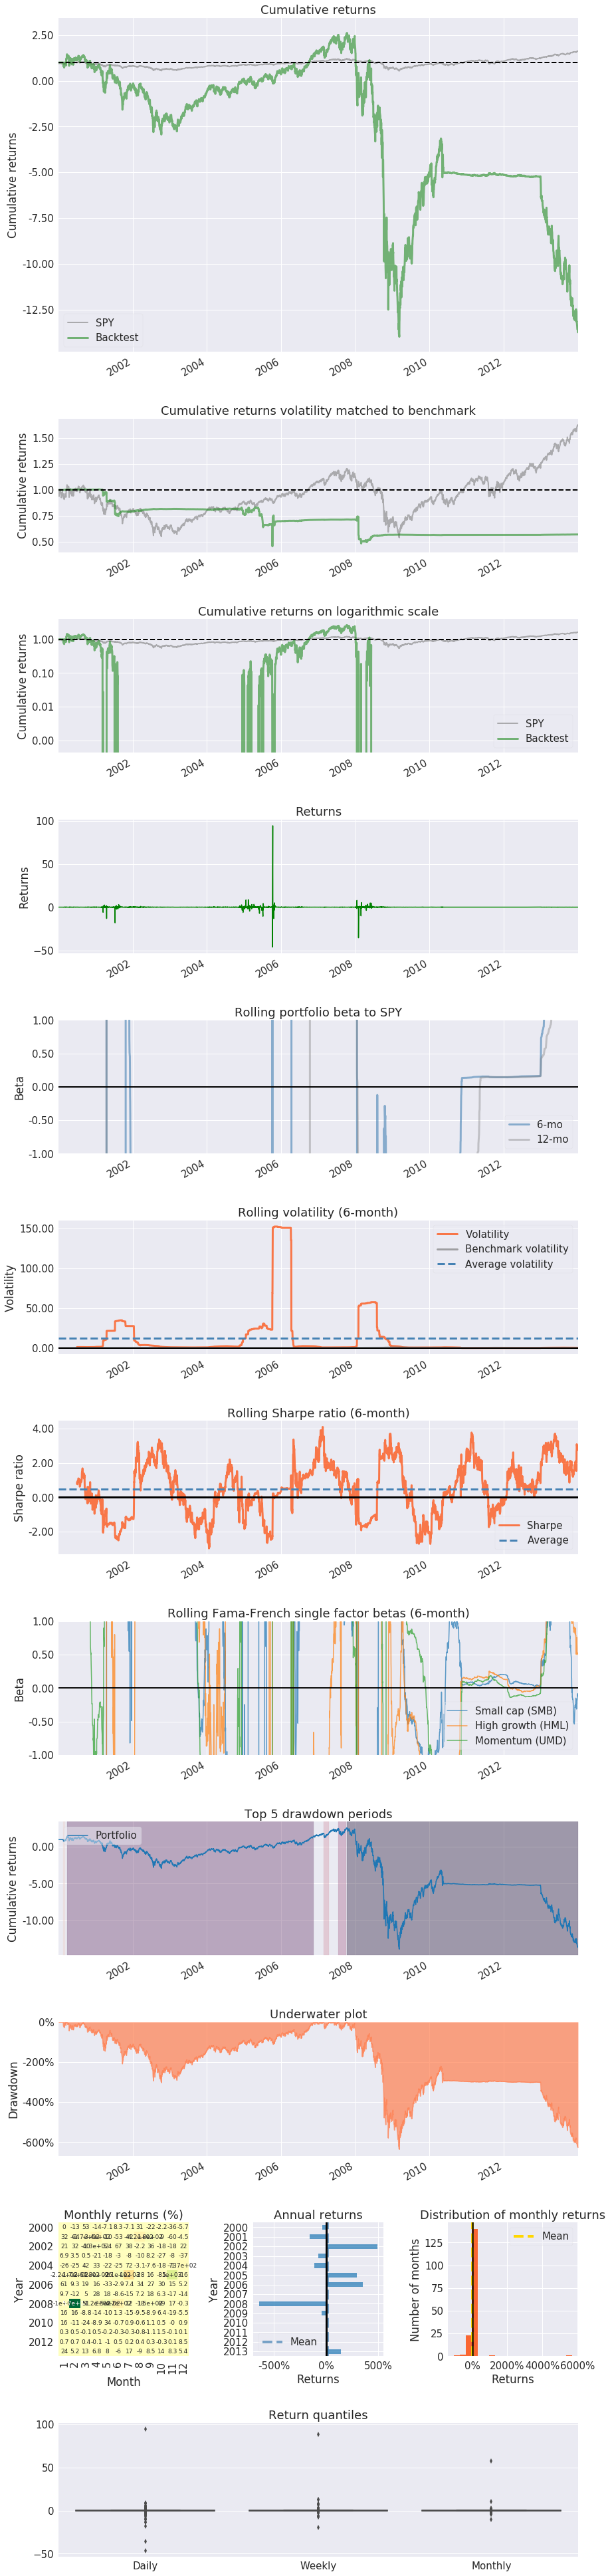

Stress Events,mean,min,max
Dotcom,0.44%,-26.53%,24.50%
Lehmann,3.60%,-27.09%,57.11%
9/11,1.21%,-17.28%,60.08%
US downgrade/European Debt Crisis,-0.01%,-0.94%,0.63%
Fukushima,0.02%,-0.28%,0.23%
US Housing,1.41%,-5.03%,7.54%
EZB IR Event,-0.01%,-0.18%,0.26%
Aug07,0.60%,-14.70%,11.70%
Mar08,5.02%,-84.95%,87.05%
Sept08,6.58%,-23.33%,57.11%


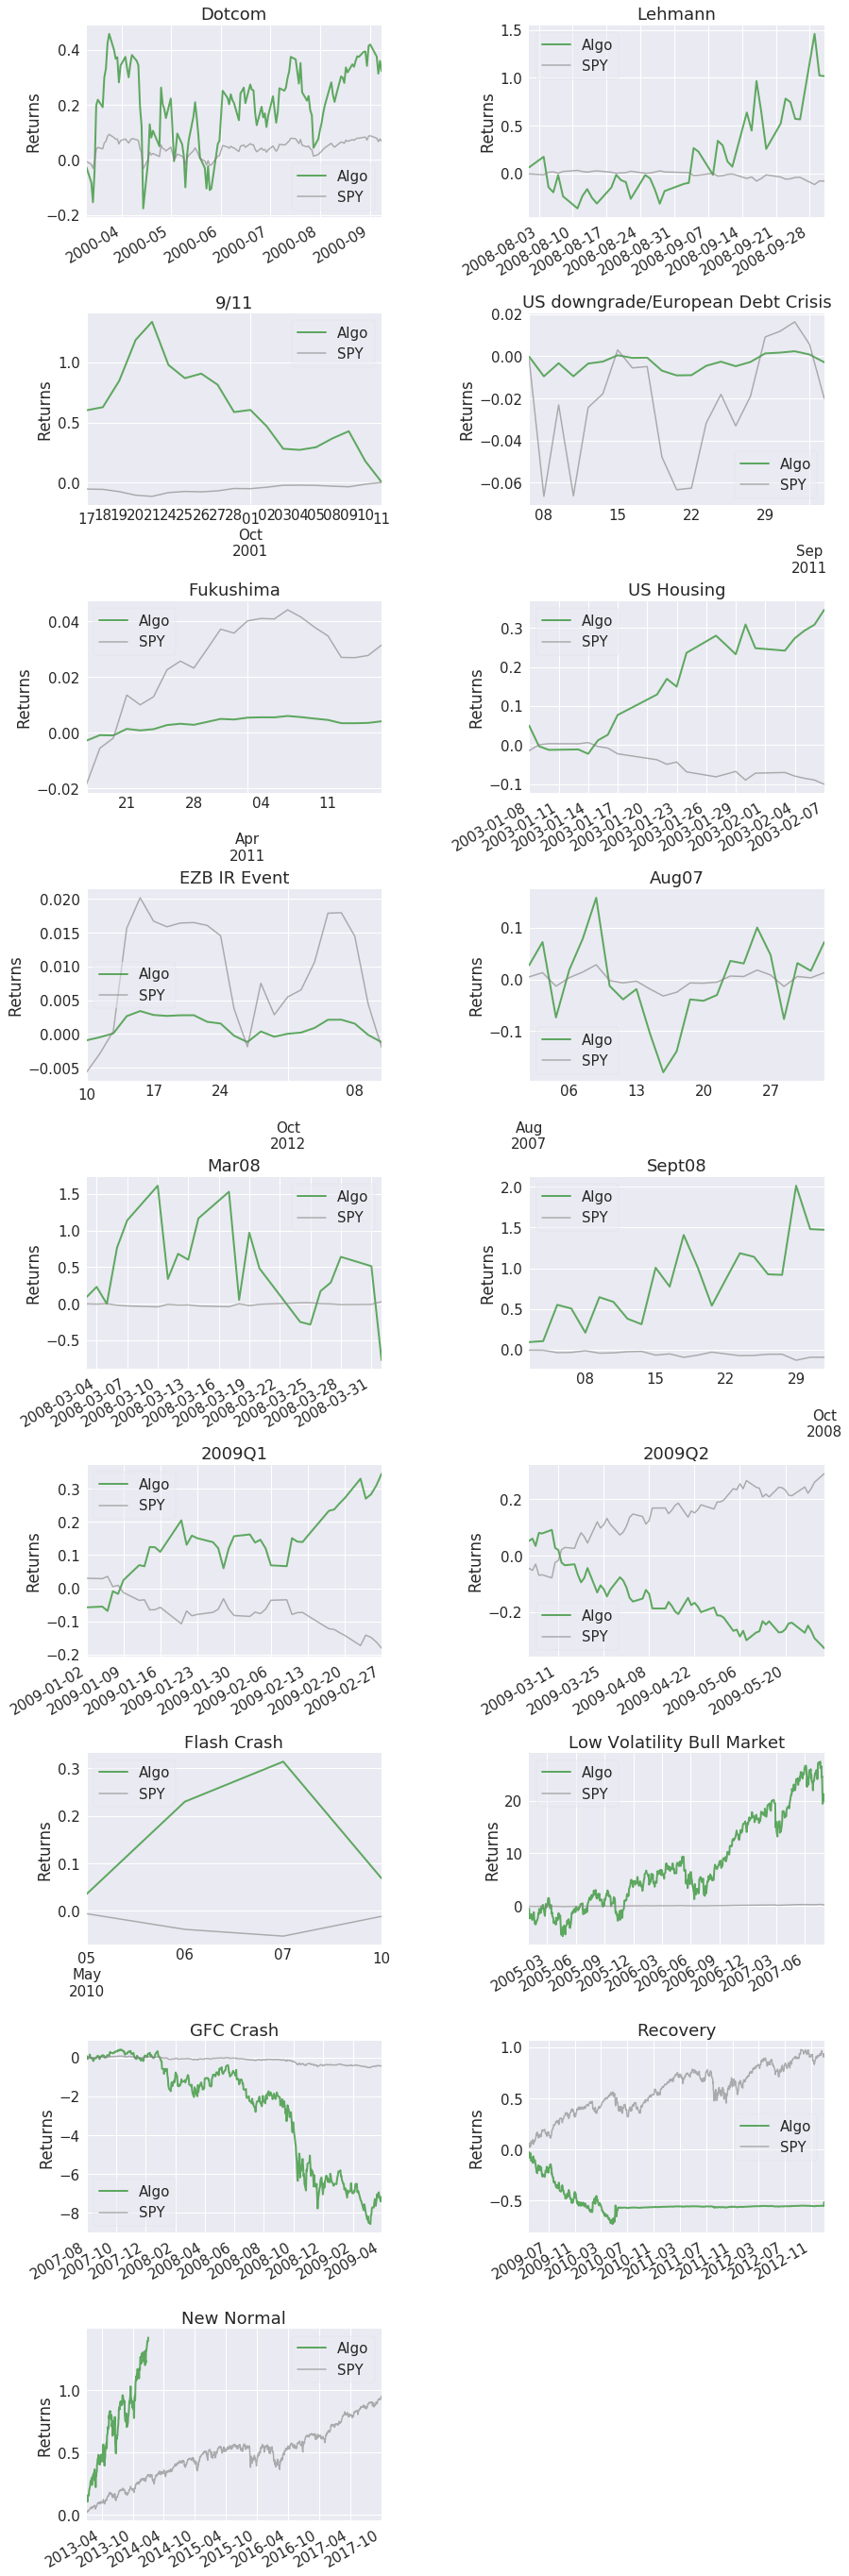

Top 10 long positions of all time,max
SPY,1287853.40%


Top 10 short positions of all time,max
SPY,-1117130.14%


Top 10 positions of all time,max
SPY,1287853.40%


All positions ever held,max
SPY,1287853.40%


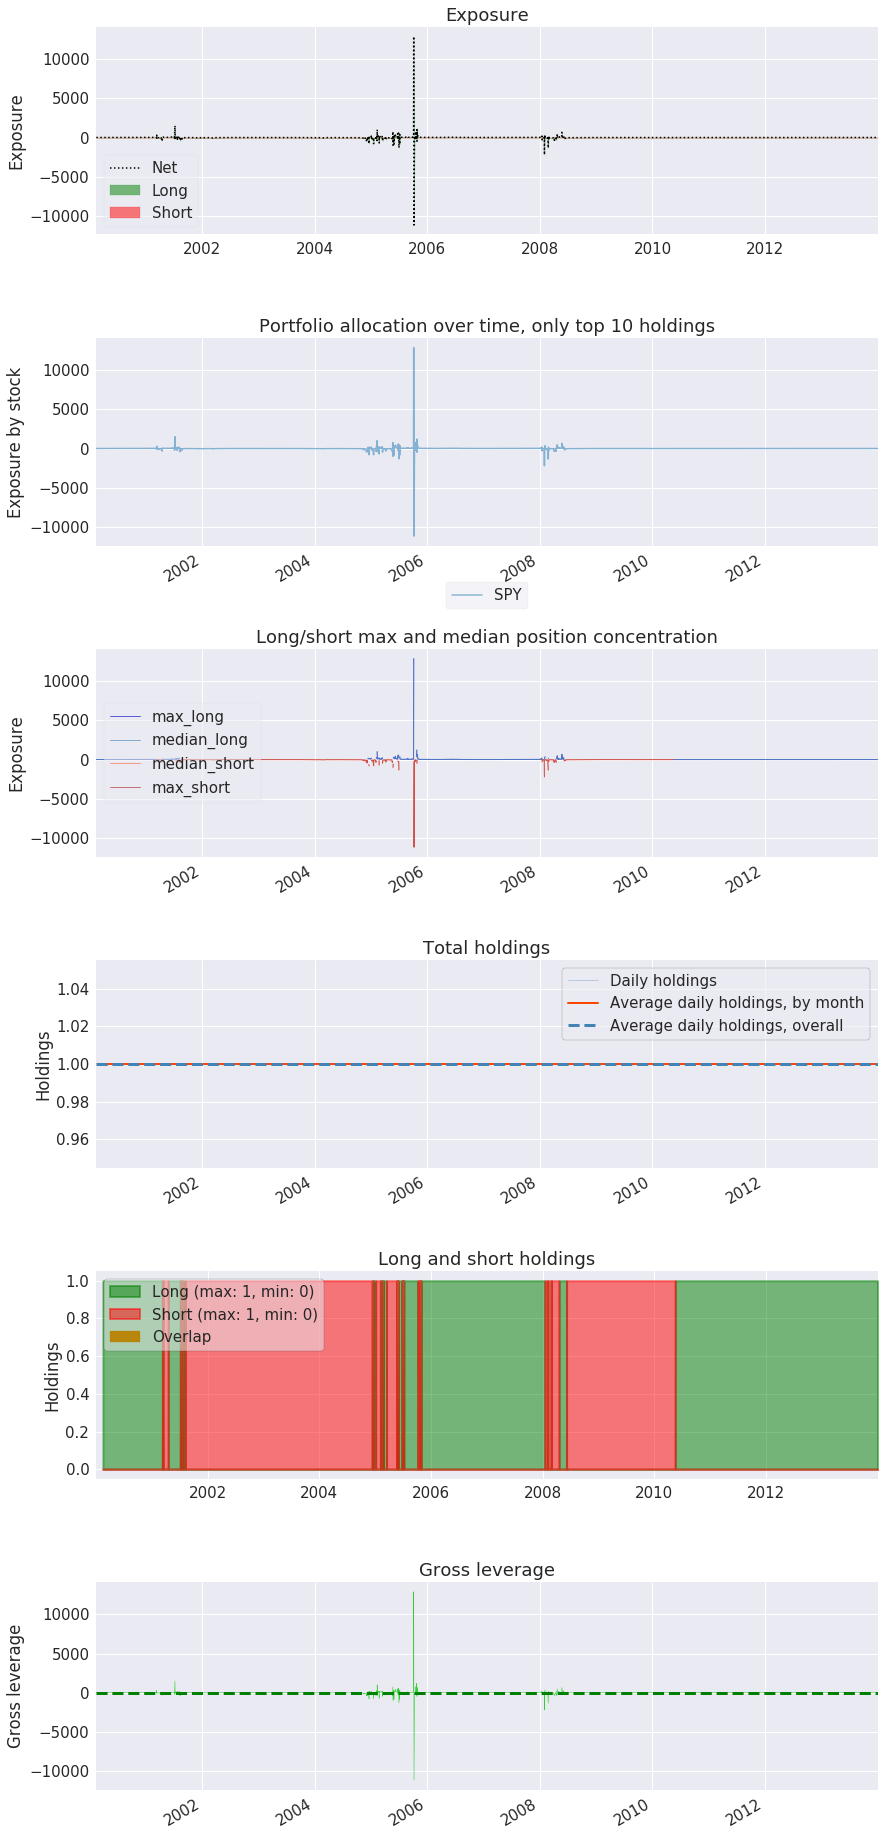

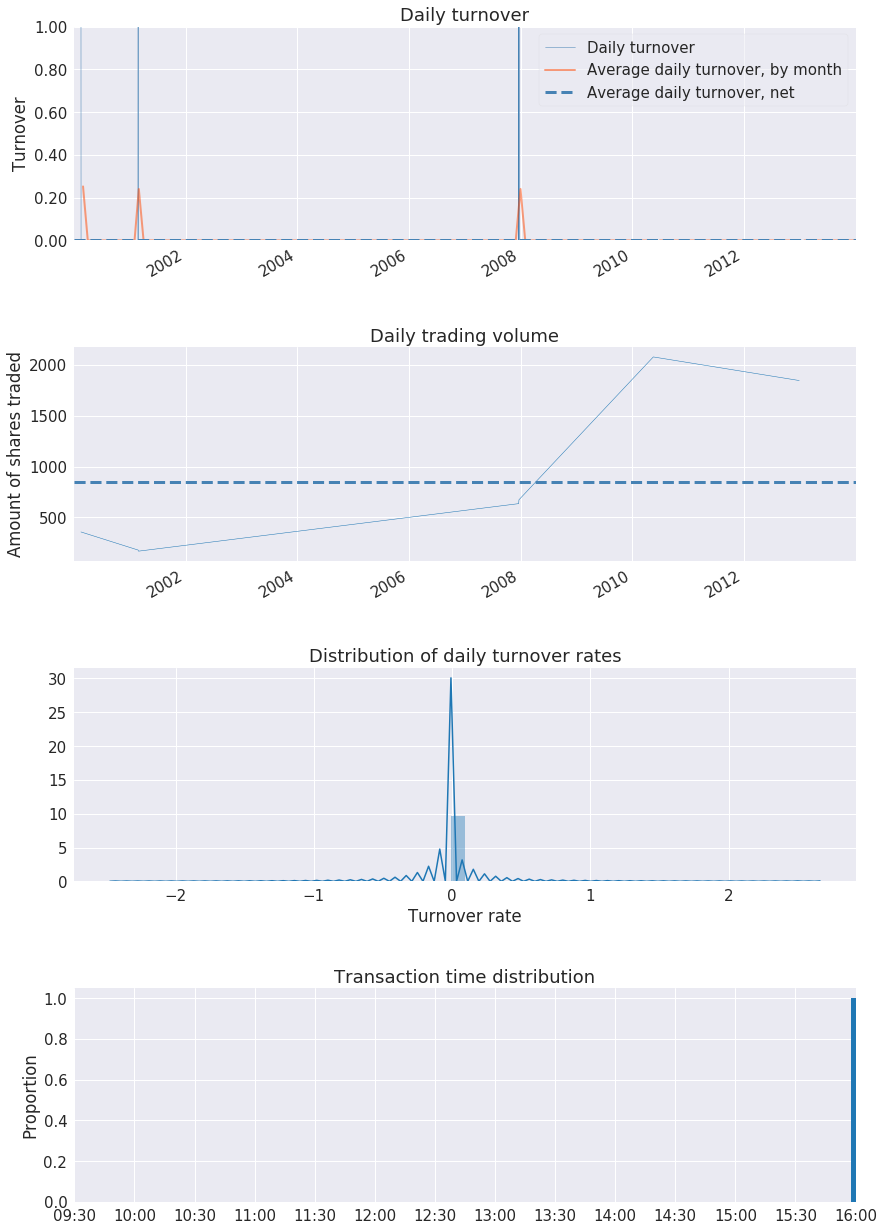

/usr/local/lib/python3.4/site-packages/pyfolio/tears.py:806: UserWarning: Fewer than 5 round-trip trades made.
               Skipping round trip tearsheet.
  Skipping round trip tearsheet.""", UserWarning)


In [15]:
pf.create_full_tear_sheet(returns, positions, transactions, round_trips=True)